# Prediksi Harga Pangan
## oleh Achmad Ichzan

## 1. IMPOR LIBRARY & KONFIGURASI

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Library Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

# Konfigurasi agar tampilan pandas rapi & warning tidak mengganggu
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

# Mengatur gaya visualisasi agar lebih cantik dan mudah dibaca
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Library berhasil diimpor.")

✅ Library berhasil diimpor.


## 2. LOAD DATA & PEMBERSIHAN AWAL (CLEANING)

In [15]:
# Membaca file
df = pd.read_csv('harga_pangan.csv', skiprows=2)

# Membersihkan nama kolom (menghapus spasi tersembunyi)
df.columns = df.columns.str.strip()

# Membersihkan format mata uang ("Rp" dan ",")
# Mengubah ke tipe data String dulu, baru replace
df['Harga'] = df['Harga'].astype(str).str.replace('Rp', '').str.replace(',', '')

# Mengubah ke tipe Numerik (Float)
# errors='coerce' mengubah data non-angka (seperti "-") menjadi NaN
df['Harga'] = pd.to_numeric(df['Harga'], errors='coerce')

# Mapping Nama Bulan ke Angka
df['Bulan'] = df['Bulan'].astype(str).str.strip()
mapping_bulan = {
    'Januari': 1, 'Februari': 2, 'Maret': 3, 'April': 4, 'Mei': 5, 'Juni': 6,
    'Juli': 7, 'Agustus': 8, 'September': 9, 'Oktober': 10, 'November': 11, 'Desember': 12
}
df['Bulan_Angka'] = df['Bulan'].map(mapping_bulan)

# Hapus baris yang gagal di-mapping (baris sampah)
df = df.dropna(subset=['Bulan_Angka'])

## 3. HANDLING MISSING VALUES (INTERPOLASI)

In [16]:
# Urutkan data agar interpolasi berjalan sesuai urutan waktu
df = df.sort_values(by=['Nama Provinsi', 'Komoditas', 'Tahun', 'Bulan_Angka'])

# Interpolasi Linear (Mengisi data bolong berdasarkan rata-rata tetangganya)
# Dilakukan per Grup (Provinsi & Komoditas) agar data tidak bocor antar daerah
df['Harga'] = df.groupby(['Nama Provinsi', 'Komoditas'])['Harga'].transform(lambda x: x.interpolate())

# Hapus data yang masih kosong (biasanya data di bulan-bulan awal periode)
df = df.dropna(subset=['Harga'])

# Hapus data Harga 0 atau Negatif (Penyebab Error MAPE)
df = df[df['Harga'] > 0]

print("✅ Data Cleaning selesai.")

✅ Data Cleaning selesai.


## 4. FEATURE ENGINEERING (REKAYASA FITUR)

In [17]:
df = df.reset_index(drop=True)

# Membuat Fitur LAG (Harga Masa Lalu)
# Shift(1) = Harga 1 Bulan Lalu
# Shift(12) = Harga 1 Tahun Lalu (Seasonality)
df['Harga_Bulan_Lalu'] = df.groupby(['Nama Provinsi', 'Komoditas'])['Harga'].shift(1)
df['Harga_3Bulan_Lalu'] = df.groupby(['Nama Provinsi', 'Komoditas'])['Harga'].shift(3)
df['Harga_Tahun_Lalu'] = df.groupby(['Nama Provinsi', 'Komoditas'])['Harga'].shift(12)

# Encoding Data Kategorikal (Mengubah Teks jadi Angka ID)
le_prov = LabelEncoder()
df['Provinsi_ID'] = le_prov.fit_transform(df['Nama Provinsi'])

le_kom = LabelEncoder()
df['Komoditas_ID'] = le_kom.fit_transform(df['Komoditas'])

# Hapus baris NaN yang muncul akibat proses Shift (Lagging)
df_clean = df.dropna()

print("✅ Feature Engineering selesai.")

✅ Feature Engineering selesai.


## 5. VISUALISASI

### a. VISUALISASI TREN HARGA (RATA-RATA NASIONAL)

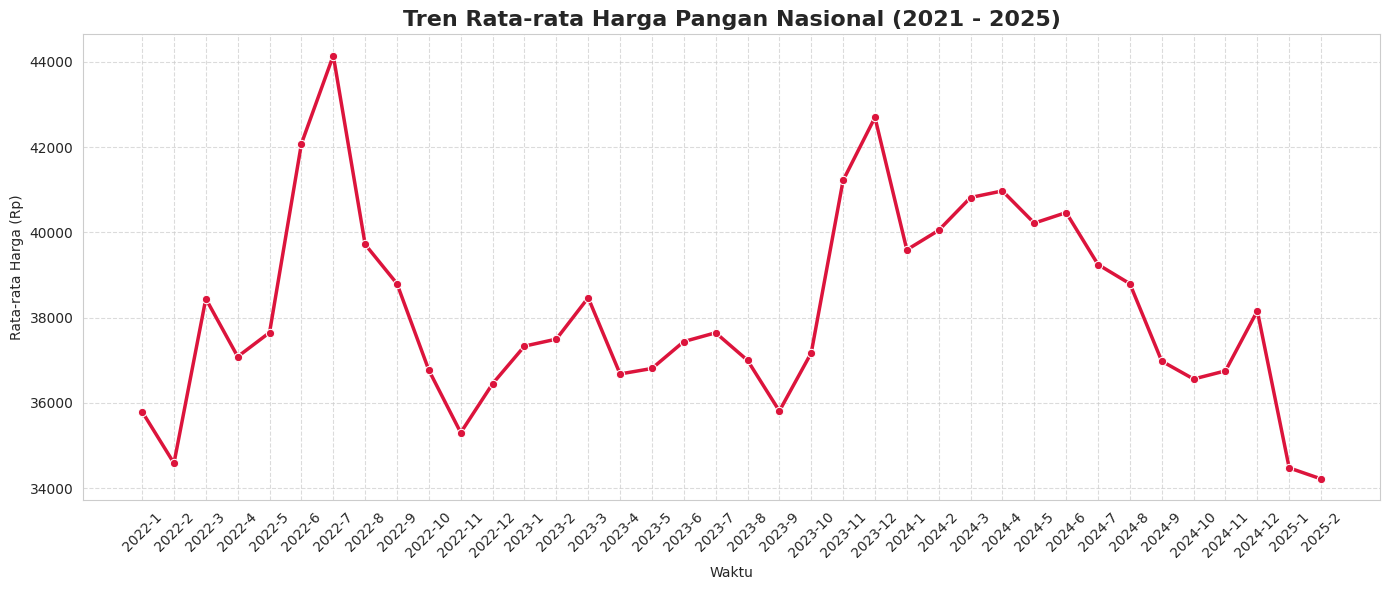

In [18]:
# Tujuannya: Melihat apakah harga pangan di Indonesia cenderung naik/turun dari 2021-2025
plt.figure(figsize=(14, 6))

# Kita kelompokkan harga berdasarkan waktu (Tahun & Bulan)
rata2_nasional = df_clean.groupby(['Tahun', 'Bulan_Angka'])['Harga'].mean().reset_index()
# Membuat kolom 'Waktu' gabungan untuk sumbu X
rata2_nasional['Waktu'] = rata2_nasional['Tahun'].astype(str) + '-' + rata2_nasional['Bulan_Angka'].astype(str)

sns.lineplot(data=rata2_nasional, x='Waktu', y='Harga', marker='o', linewidth=2.5, color='crimson')
plt.xticks(rotation=45)
plt.title('Tren Rata-rata Harga Pangan Nasional (2021 - 2025)', fontsize=16, fontweight='bold')
plt.ylabel('Rata-rata Harga (Rp)')
plt.xlabel('Waktu')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### b. DISTRIBUSI HARGA PER KOMODITAS (BOXPLOT)

/tmp/ipython-input-1184806346.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x='Harga', y='Komoditas', order=urutan_mahal, palette='viridis')


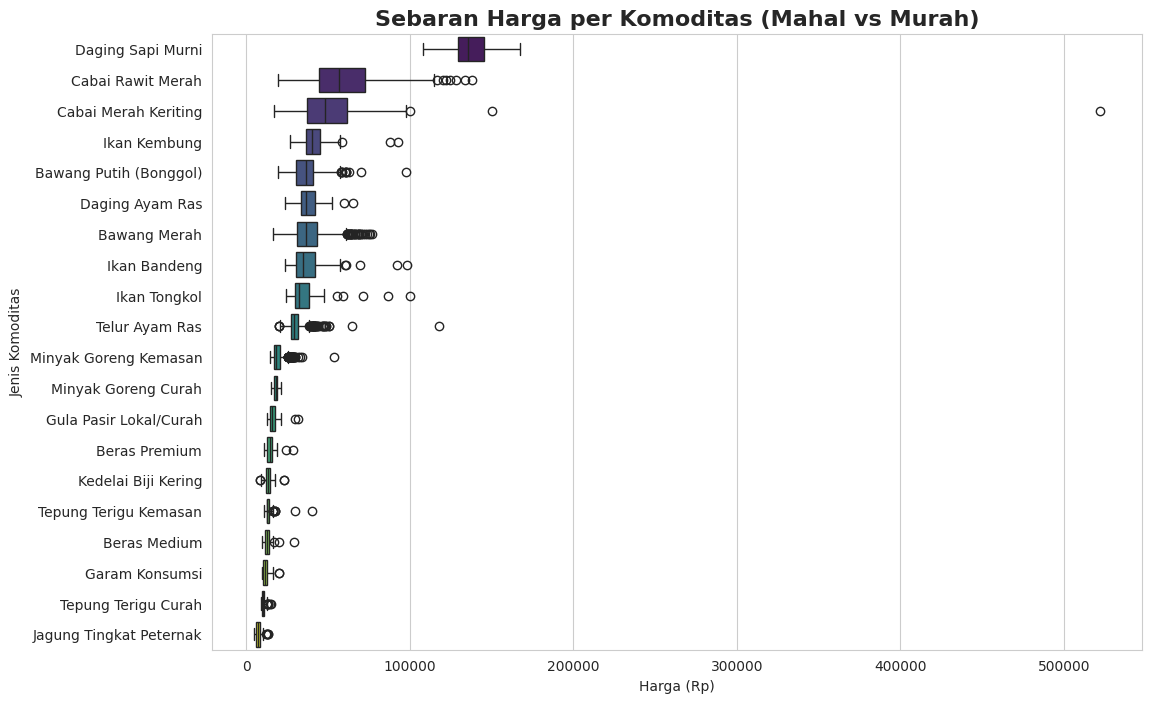

In [19]:
# Tujuannya: Membandingkan harga antar barang. Mana yang paling mahal? Mana yang paling stabil?
plt.figure(figsize=(12, 8))

# Urutkan komoditas dari yang median harganya paling mahal ke paling murah
urutan_mahal = df_clean.groupby('Komoditas')['Harga'].median().sort_values(ascending=False).index

sns.boxplot(data=df_clean, x='Harga', y='Komoditas', order=urutan_mahal, palette='viridis')
plt.title('Sebaran Harga per Komoditas (Mahal vs Murah)', fontsize=16, fontweight='bold')
plt.xlabel('Harga (Rp)')
plt.ylabel('Jenis Komoditas')
plt.show()

### c. TOP 10 PROVINSI DENGAN HARGA PANGAN TERMAHAL & TERMURAH

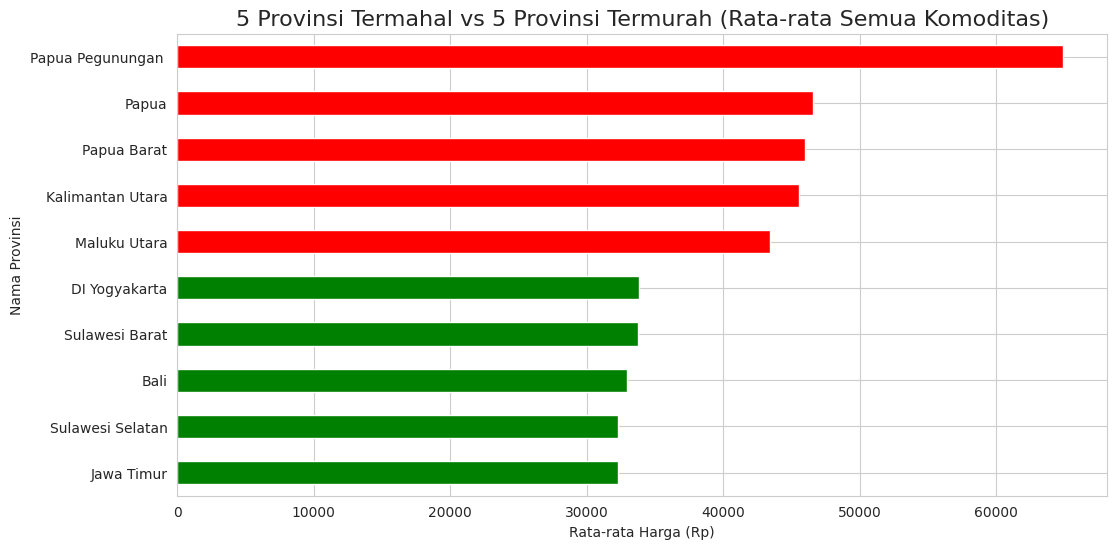

In [20]:
# Tujuannya: Melihat ketimpangan harga antar daerah
rata2_provinsi = df_clean.groupby('Nama Provinsi')['Harga'].mean().sort_values()

# Ambil 5 Termurah dan 5 Termahal
top_bottom_prov = pd.concat([rata2_provinsi.head(5), rata2_provinsi.tail(5)])

plt.figure(figsize=(12, 6))
colors = ['green']*5 + ['red']*5  # Hijau untuk murah, Merah untuk mahal
top_bottom_prov.plot(kind='barh', color=colors)
plt.title('5 Provinsi Termahal vs 5 Provinsi Termurah (Rata-rata Semua Komoditas)', fontsize=16)
plt.xlabel('Rata-rata Harga (Rp)')
plt.show()

### d. KORELASI ANTAR FITUR (HEATMAP)

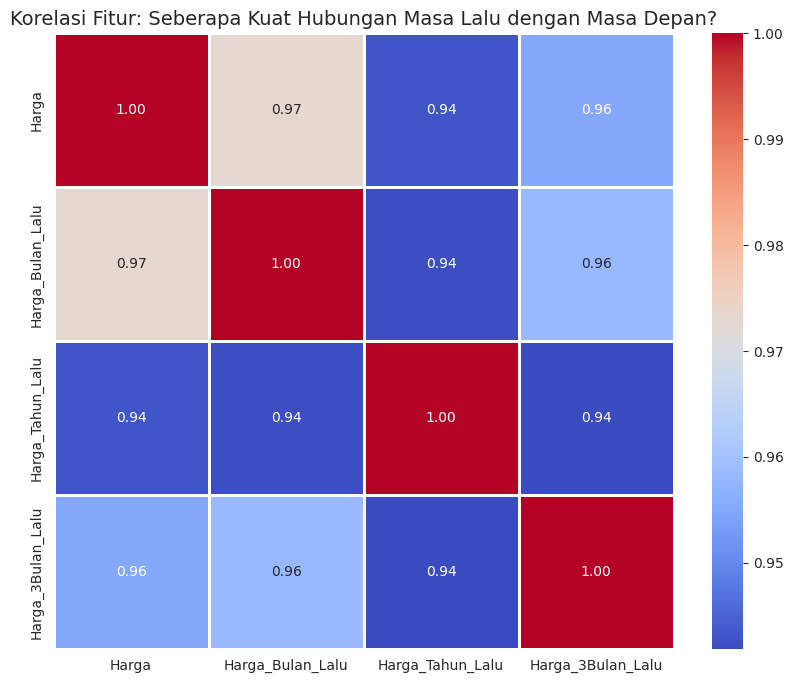

In [21]:
# Tujuannya: Membuktikan secara statistik bahwa "Harga Bulan Lalu" memang mempengaruhi "Harga Sekarang"
plt.figure(figsize=(10, 8))

# Pilih hanya kolom numerik
kolom_numerik = ['Harga', 'Harga_Bulan_Lalu', 'Harga_Tahun_Lalu', 'Harga_3Bulan_Lalu']
korelasi = df_clean[kolom_numerik].corr()

sns.heatmap(korelasi, annot=True, cmap='coolwarm', fmt=".2f", linewidths=1)
plt.title('Korelasi Fitur: Seberapa Kuat Hubungan Masa Lalu dengan Masa Depan?', fontsize=14)
plt.show()

## 6. SPLIT DATA & TRAINING MODEL

In [22]:
# Definisi Fitur (X) dan Target (y)
features = ['Harga_Bulan_Lalu', 'Harga_Tahun_Lalu', 'Bulan_Angka', 'Provinsi_ID', 'Komoditas_ID']
target = 'Harga'

# Time Series Split (Potong berdasarkan Tahun)
# Training: Data sebelum 2024
# Testing: Data 2024 ke atas
X_train = df_clean[df_clean['Tahun'] < 2024][features]
y_train = df_clean[df_clean['Tahun'] < 2024][target]

X_test = df_clean[df_clean['Tahun'] >= 2024][features]
y_test = df_clean[df_clean['Tahun'] >= 2024][target]

# Inisialisasi & Latih Model Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print(f"✅ Model berhasil dilatih! (Train: {len(X_train)} baris, Test: {len(X_test)} baris)")

✅ Model berhasil dilatih! (Train: 9772 baris, Test: 6411 baris)


## 7. EVALUASI MODEL


--- HASIL EVALUASI ---
Rata-rata Meleset (MAE): Rp 2,592
Tingkat Kesalahan (MAPE): 6.91%
Akurasi (100% - MAPE): 93.09%
R-Squared Score: 0.97


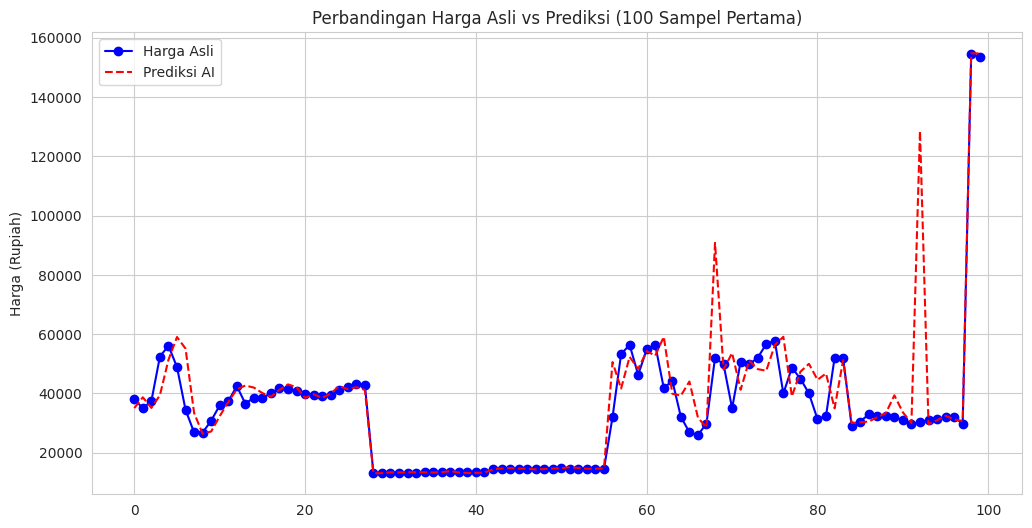

In [23]:
prediksi = model.predict(X_test)

mae = mean_absolute_error(y_test, prediksi)
mape = mean_absolute_percentage_error(y_test, prediksi)
r2 = r2_score(y_test, prediksi)

print(f"\n--- HASIL EVALUASI ---")
print(f"Rata-rata Meleset (MAE): Rp {mae:,.0f}")
print(f"Tingkat Kesalahan (MAPE): {mape*100:.2f}%")
print(f"Akurasi (100% - MAPE): {100 - (mape*100):.2f}%")
print(f"R-Squared Score: {r2:.2f}")

# Visualisasi 100 data pertama
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:100], label='Harga Asli', color='blue', marker='o')
plt.plot(prediksi[:100], label='Prediksi AI', color='red', linestyle='--')
plt.title("Perbandingan Harga Asli vs Prediksi (100 Sampel Pertama)")
plt.ylabel("Harga (Rupiah)")
plt.legend()
plt.grid(True)
plt.show()

## 8. FUNGSI PREDIKSI (INFERENCE)

In [24]:
def prediksi_harga_bulan_depan(provinsi, komoditas, bulan_depan_angka):
    """
    Fungsi untuk memprediksi harga bulan depan untuk user.
    """
    # Filter data history
    data_filter = df_clean[
        (df_clean['Nama Provinsi'] == provinsi) &
        (df_clean['Komoditas'] == komoditas)
    ].sort_values(by=['Tahun', 'Bulan_Angka'], ascending=False)

    if data_filter.empty:
        return f"Data untuk {provinsi} - {komoditas} tidak ditemukan."

    # Ambil data paling baru
    data_terakhir = data_filter.iloc[0]
    harga_bulan_ini = data_terakhir['Harga']

    # Cari harga tahun lalu (untuk fitur seasonality)
    data_tahun_lalu = df_clean[
        (df_clean['Nama Provinsi'] == provinsi) &
        (df_clean['Komoditas'] == komoditas) &
        (df_clean['Bulan_Angka'] == bulan_depan_angka) &
        (df_clean['Tahun'] == data_terakhir['Tahun'] - 1)
    ]

    # Fallback jika data tahun lalu kosong
    if data_tahun_lalu.empty:
        harga_tahun_lalu = data_filter['Harga'].mean()
    else:
        harga_tahun_lalu = data_tahun_lalu.iloc[0]['Harga']

    # Encoding input user
    try:
        prov_id = le_prov.transform([provinsi])[0]
        kom_id = le_kom.transform([komoditas])[0]
    except:
        return "Provinsi atau Komoditas tidak dikenali."

    # Siapkan DataFrame input
    input_data = pd.DataFrame([[
        harga_bulan_ini,
        harga_tahun_lalu,
        bulan_depan_angka,
        prov_id,
        kom_id
    ]], columns=features)

    # Prediksi
    hasil_prediksi = model.predict(input_data)[0]

    return (f"--- PREDIKSI AI ---\n"
            f"Lokasi: {provinsi}\n"
            f"Komoditas: {komoditas}\n"
            f"Data Terakhir: {data_terakhir['Bulan']} {data_terakhir['Tahun']} (Rp {harga_bulan_ini:,.0f})\n"
            f"PREDIKSI Bulan Ke-{bulan_depan_angka}: Rp {hasil_prediksi:,.0f}")

# Contoh Penggunaan
print("\n--- CONTOH PENGGUNAAN ---")
print(prediksi_harga_bulan_depan("Aceh", "Bawang Merah", 11))


--- CONTOH PENGGUNAAN ---
--- PREDIKSI AI ---
Lokasi: Aceh
Komoditas: Bawang Merah
Data Terakhir: Februari 2025 (Rp 36,604)
PREDIKSI Bulan Ke-11: Rp 37,539


## 9. MENYIMPAN MODEL (DEPLOYMENT)

In [25]:
model_package = {
    'model_rf': model,
    'le_prov': le_prov,
    'le_kom': le_kom,
    'data_ref': df_clean
}

joblib.dump(model_package, 'model_prediksi_harga_pangan.pkl')
print("\n✅ Model berhasil disimpan ke file .pkl")


✅ Model berhasil disimpan ke file .pkl
